<font size="5">ライブラリのインストール</font>

In [1]:
# !pip install jupyter-contrib-nbextensions
# !pip install jupyter-nbextensions-configurator

# !jupyter contrib nbextension install
# !jupyter nbextensions_configurator enable
# !pip install torchsummary

<font size="5">ライブラリのインポート

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

<font size="5">cpuとgpuの選択

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [4]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [5]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")


Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [6]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [7]:
batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset_original, batch_size=1, shuffle=True)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=0
y[9]=0


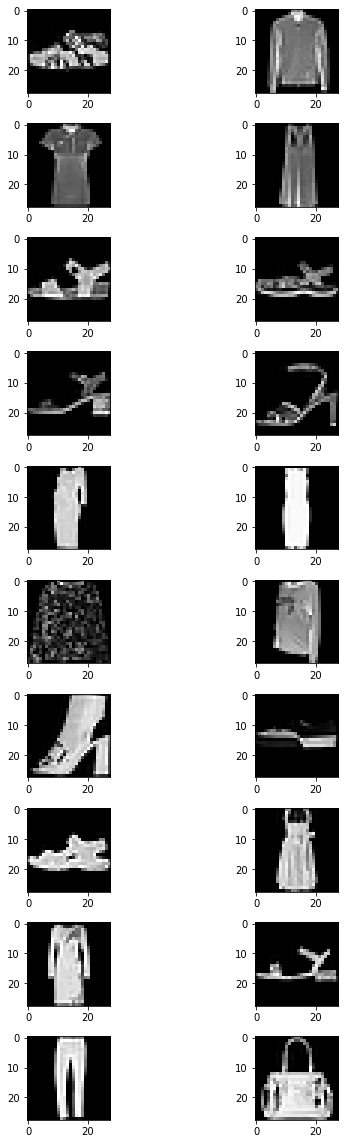

In [8]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [15]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


xのshape tensor([[ 0.2709,  0.3395, -0.0590,  ...,  0.1087,  0.1752,  0.1169],
        [ 0.1530,  0.3300, -0.0584,  ...,  0.2382, -0.6250,  0.1942],
        [ 0.4561, -0.3521, -0.0638,  ..., -0.1682, -0.1133,  0.2373],
        ...,
        [-0.2675, -0.3258,  0.0313,  ...,  0.2624, -0.0082,  0.2401],
        [ 0.2742,  0.0520, -0.5492,  ...,  0.1038,  0.0082,  0.7353],
        [ 0.4623, -0.6884, -0.3406,  ..., -0.6263, -0.3771,  0.0680]],
       device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([8, 256])

In [17]:
# # Siamse Networkモデルクラス
# class SiameseMnistModel(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()

#         self.encoder = nn.Sequential(
#             nn.Linear(28*28, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 32)
#         )
    
#     def forward_once(self, x):
#         x = self.flatten(x)
#         z = self.encoder(x)
#         return z
  
#     def forward(self, x1, x2):
#         z1 = self.forward_once(x1)
#         z2 = self.forward_once(x2)
#         return z1, z2

# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


In [11]:
# class SiameseNetwork(nn.Module):
#     """
#     Siamese Network using the Base Network to compute embeddings.
#     Computes the Euclidean distance between the embeddings of two input images.
#     """
#     def __init__(self, base_network):
#         super().__init__()
#         self.base_network = base_network

#     def forward_one(self, x):
#         """
#         Forward pass for one input.
#         """
#         return self.base_network(x)

#     def forward(self, input1, input2):
#         """
#         Forward pass for both inputs.
#         """
#         output1 = self.forward_one(input1)
#         output2 = self.forward_one(input2)

#         # Compute Euclidean distance
#         dist = F.pairwise_distance(output1, output2, keepdim=True)

#         return dist

# # Test the Siamese network with sample inputs
# siamese_net = SiameseNetwork(base_network).to(device)
# sample_input1 = torch.randn(8, 1, 28, 28).to(device)
# sample_input2 = torch.randn(8, 1, 28, 28).to(device)
# sample_dist = siamese_net.forward(sample_input1, sample_input2)

# sample_dist.shape  # Expected: [8, 1]

<font size="5">損失関数

In [18]:
# class ContrastiveLoss(nn.Module):
#     """
#     Contrastive loss for Siamese Networks.
#     """
#     def __init__(self, margin=2.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, dist, label):
#         """
#         Compute contrastive loss.

#         Args:
#         - dist: Euclidean distance between the embeddings of two input images.
#         - label: 1 if the images are from the same class, 0 otherwise.
#         """
#         loss = (1/2) * label * torch.pow(dist, 2) + \
#                (1/2) * (1 - label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
#         return loss.mean()

# # Define the loss function and optimizer
# criterion = ContrastiveLoss().to(device)
# optimizer = optim.RMSprop(siamese_net.parameters(), lr=0.001)  # Using RMSprop as in the Keras example

# # Quick test of the loss function
# sample_label = torch.tensor([1, 0, 1, 0, 1, 0, 1, 0], dtype=torch.float32).to(device).unsqueeze(1)  # Simulating same and different classes
# loss_value = criterion(sample_dist, sample_label)
# loss_value.item()

# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (y * distance_squared + (1 - y) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">学習の準備

In [19]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

In [14]:
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# モデル学習
repeat = 40                                                       # 学習回数
losses = []                                                       # 表示用損失値配列

model.train()                                                     # 学習モード
for epoch in range(repeat): 
  print(f"epoch={epoch}")
  nan_count = 0
  normal_count = 0

  # tqdmを使って学習の進行状況を表示
  for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
    # モデルによる特徴ベクトル算出
    output1, output2 = model(X1.to(device), X2.to(device))

    # 損失関数の計算
    loss = criterion(output1, output2, y.to(device))

    # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
    if torch.isnan(loss):
      model = prev_model
      optimizer = optim.SGD(model.parameters(), lr=0.05)
      optimizer.load_state_dict(prev_optimizer.state_dict())
      nan_count += 1
      continue
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
      normal_count += 1

    # 表示用lossデータの記録
    losses.append(loss.item())

    # 勾配を初期化
    optimizer.zero_grad()
    
    # 損失関数の値から勾配を求め誤差逆伝播による学習実行
    loss.backward()
    
    # 学習結果に基づきパラメータを更新
    optimizer.step()

  print(f"nan/normal: {nan_count}/{normal_count}")
plt.plot(losses)                                                  # loss値の推移を表示


epoch=0



nan/normal: 3/935
epoch=1



nan/normal: 3/935
epoch=2



nan/normal: 3/935
epoch=3



nan/normal: 3/935
epoch=4



nan/normal: 3/935
epoch=5



nan/normal: 3/935
epoch=6



nan/normal: 3/935
epoch=7



nan/normal: 3/935
epoch=8



nan/normal: 3/935
epoch=9



nan/normal: 3/935
epoch=10


KeyboardInterrupt: 

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [ ]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)                                 # スカラ要素(int)リストをtorch.tensor化

In [ ]:
# 次元数の確認
print(z_test.size())
print(y_test.size())

z_testとy_testをGPUに移動

In [ ]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)

<font size="5">モデル出力ベクトルの分布可視化

32次元ベクトルを2次元二次元削減して、出力ベクトルの分布を見てみる。

①　そのまま可視化

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    # print(x_embedded.size())
    
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(10):  # クラスごとに色を分けてプロット
            # 正距方位図法へ写像するプログラムを追加
            
            ax.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], x_embedded[y == i, 2], color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
    
    plt.show()


# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)



②　ノイズクラスタリングを各クラスに適応してクラス中心を算出

In [ ]:
# a=np.zeros((10, 3))
# cent=np.zeros((10,3))
# print(a.shape)
# a[0]=[1,2,3]
# a[3]=[10,0,20]
# print(a)
# cent[1]=np.mean(a, axis=0)
# print(cent)

In [ ]:
from sklearn.cluster import DBSCAN
def plot_tsne_interactive(x, y, dimension=3):
    cluster_num=10
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    centroid=np.zeros((cluster_num, dimension))
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(cluster_num):  # クラスごとに色を分けてプロット
            # DBSCANを適用する
            dbscan = DBSCAN(eps=2, min_samples=2)
            dbscan.fit(x_embedded)
            # 欠損値の削除
            data=x_embedded[y==i]
            new_data=data[~np.isnan(data).any(axis=1)]
            print("欠損値削除前の形状", data.shape)
            print("欠損値削除後の形状", new_data.shape)
            centroid[i]=np.mean(new_data, axis=0)
            print("目的クラスの重心：\n", centroid)
            ax.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], x_embedded[y == i, 2], color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    plt.show()
    return centroid


# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
cluster_center=plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
print(cluster_center.shape)
print(cluster_center)

In [ ]:
# 重心算出結果の確認
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3Dプロットを行うためのモジュール


# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # 3Dプロットを設定

# データをプロット
for i in range(10):
    x, y, z = cluster_center[i]  # 三次元座標を取得
    ax.scatter(x, y, z, marker='*', s=100, label=f'Class {i+1}')

# 軸ラベルを設定
ax.set_xlabel('X軸')
ax.set_ylabel('Y軸')
ax.set_zlabel('Z軸')

# グラフのタイトルと凡例を設定
ax.set_title('3D Scatter Plot')
ax.legend()

# グラフを表示
plt.show()

③　単位球面上に射影(算出した重心も同じ処理をする)＋可視化

In [ ]:
tsne = TSNE(n_components=3, random_state = 0, perplexity = 30, n_iter = 1000)
x_embedded = tsne.fit_transform(z_test_np)
print(x_embedded.shape)
# print(x_embedded)

In [ ]:
def norm(data):
#     print("in")
    norm_data=data.copy()
    # dataの形
#     print(data.shape)
#     print(data[0].shape)
    for i in range(len(data)):
        norm_data[i]=data[i]/np.linalg.norm(data[i], ord=2)
#     print(norm_data)
#     print("out")
    return norm_data

# print(x_embedded)
y=y_test_np
print(x_embedded[y==1].shape)
a=norm(x_embedded[y==1])
print(a)
print(a.shape)
print(a[:, 0].shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# すべての点をプロット
ax.scatter(a[:, 0], a[:, 1], a[:, 2], marker='o')  # 'o'は点を表す
# ax.set_xlim(-1, 1)  # x軸の範囲を設定
# ax.set_ylim(-1, 1)  # y軸の範囲を設定
# ax.set_zlim(-1, 1)  # z軸の範囲を設定

# グラフを表示
plt.show()

In [ ]:
# 算出したセンターの単位球上への写像
norm_cluster_center=norm(cluster_center)
print(norm_cluster_center)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # 3Dプロットを設定

# データをプロット
for i in range(10):
    x, y, z = norm_cluster_center[i]  # 三次元座標を取得
    ax.scatter(x, y, z, marker='*', s=100, label=f'Class {i+1}')

# 軸ラベルを設定
ax.set_xlabel('X軸')
ax.set_ylabel('Y軸')
ax.set_zlabel('Z軸')

# グラフのタイトルと凡例を設定
ax.set_title('3D Scatter Plot')
ax.legend()

# グラフを表示
plt.show()

In [ ]:
# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 100)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 100)  # 経度角の範囲

# 球体の座標を計算
phi, theta = np.meshgrid(phi, theta)
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# 3Dプロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 球体をプロット
ax.plot_surface(x, y, z, color='w', alpha=0.6)
# データをプロット
for i in range(10):
    x, y, z = norm_cluster_center[i]  # 三次元座標を取得
    ax.scatter(x, y, z, marker='*', s=100, label=f'Class {i+1}')

# グラフをカスタマイズ
ax.set_xlabel('X軸')
ax.set_ylabel('Y軸')
ax.set_zlabel('Z軸')
ax.set_title('立体的な球体のプロット')

# グラフを表示
plt.show()

In [ ]:
# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 100)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 100)  # 経度角の範囲

# 球体の座標を計算
phi, theta = np.meshgrid(phi, theta)
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# 3Dプロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 球体をプロット
ax.plot_surface(x, y, z, color='w', alpha=0.6)
# データをプロット
for i in range(10):
    x, y, z = cluster_center[i]  # 三次元座標を取得
    ax.scatter(x, y, z, marker='*', s=100, label=f'Class {i+1}')

# グラフをカスタマイズ
ax.set_xlabel('X軸')
ax.set_ylabel('Y軸')
ax.set_zlabel('Z軸')
ax.set_title('立体的な球体のプロット')

# グラフを表示
plt.show()

In [ ]:
# 正規化関数
def norm(data):
    print("in")
    norm_data=data.copy()
    # dataの形
    print(data.shape)
    print(data[0].shape)
    for i in range(len(data)):
        norm_data[i]=data[i]/np.linalg.norm(data[i], ord=2)
#     print(norm_data)
    print("out")
    return norm_data

def plot_tsne_interactive(x, y, dimension=3):
    cluster_num=10
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    centroid=np.zeros((cluster_num, dimension))
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(10):  # クラスごとに色を分けてプロット
            # 単位球面上に射影
            norm_data=norm(x_embedded[y==i])
            print(norm_data)
            print(norm_data.shape)
            ax.scatter(norm_data[:, 0], norm_data[:, 1], norm_data[:, 2], color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    plt.show()
    return centroid


# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
cluster_center=plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
# def project_to_unit_sphere(x, y, z):
#     """
#     Projects the 3D coordinates (x, y, z) onto the unit sphere.
#     """
#     distance = np.sqrt(x**2 + y**2 + z**2)
#     normalized_x = x / distance
#     normalized_y = y / distance
#     normalized_z = z / distance
#     return normalized_x, normalized_y, normalized_z



# # # 重心を計算する
# def calc_cen(points):
#     print("クラスのデータ")
#     print(points.shape)
#     # 各座標の合計を計算
#     centroid = np.mean(points, axis=0)
# #     print(centroid.shape)
# #     print(centroid) #[-0.73519397 -0.47938463  0.15791151]
#     return centroid


# def move(points):
#     print(points.shape)
#     print(points[0].shape)
#     # 重心座標を計算
#     centroid = calc_cen(points)
#     print(centroid)

#     # 重心座標を原点として平行移動
#     goal=np.array([0,0,1])
#     vecter=goal-centroid
#     print("vecter:",vecter)
#     translated_points = points + vecter
#     print("points:",points[0])
#     print("translated_points:", translated_points[0])
#     data=norm(translated_points)
#     return data


# # 正規化関数
# def norm(data):
#     print("in")
#     norm_data=data.copy()
#     # dataの形
# #     print(data.shape)
#     for i in range(len(data)):
#         norm_data[i]=data[i]/np.linalg.norm(data[i])
# #     print(norm_data)
#     print("out")
#     return norm_data

# def plot_tsne_interactive(x, y, dimension=3):
#     cluster_num=10
#     # tsne = TSNE(n_components=dimension)
#     tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
#     x_embedded = tsne.fit_transform(x)
#     centroid=np.zeros((cluster_num, dimension))
#     plt.figure(figsize=(13, 10))
#     if dimension == 3:
#         ax = plt.subplot(111, projection='3d')
#         for i in range(cluster_num):  # クラスごとに色を分けてプロット
#             # DBSCANを適用する
#             dbscan = DBSCAN(eps=2, min_samples=2)
#             dbscan.fit(x_embedded)
#             data=x_embedded[y==i]
#             new_data=data[~np.isnan(data).any(axis=1)]
#             centroid[i]=np.mean(new_data, axis=0)
#             ax.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], x_embedded[y == i, 2], color=colors[i], label=class_names[i])
#         ax.legend()  # 凡例の追加
#     plt.show()
#     return centroid


# # t-SNEによるベクトル分布表示
# # GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
# z_test_np = z_test.cpu().detach().numpy().copy()
# y_test_np = y_test.cpu().detach().numpy().copy()
# plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

④　データの回転

In [ ]:
# 回転行列を計算する関数
def rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    axis /= np.linalg.norm(axis)
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


def plot_tsne_interactive(x, y, dimension=3):
    cluster_num=10
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    centroid=np.zeros((cluster_num, dimension))
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(1):  # クラスごとに色を分けてプロット
            # 単位球面上に射影
            norm_data=norm(x_embedded[y==i])
            # 回転
            # 回転させるベクトル
            vector = np.array([-0.9687773, 0.07260493, -0.23706354])
            # x 軸周りの回転角度（ラジアン）を計算
            # 目標ベクトルが [0, 0, 1] になるように回転するために必要な角度を求める
            target_vector = np.array([0, 0, 1])
            cos_theta = np.dot(vector, target_vector) / (np.linalg.norm(vector) * np.linalg.norm(target_vector))
            theta = np.arccos(cos_theta)
            # x 軸を中心に回転行列を計算
            rotation_axis = [1, 0, 0]
            rotation_matrix_x = rotation_matrix(rotation_axis, theta)

            # ベクトルを回転
#             rotated_vector = np.dot(rotation_matrix_x, vector)
            rotated_vector = np.dot(rotation_matrix_x, norm_data)
            print(rotated_vector.shape)
#             ax.scatter(norm_data[:, 0], norm_data[:, 1], norm_data[:, 2], color=colors[i], label=class_names[i])
            ax.scatter(rotated_vector[:, 0], rotated_vector[:, 1], rotated_vector[:, 2], color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    plt.show()
    return centroid


# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
cluster_center=plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def azimuthal_equidistant_projection(x, y, z):
    """
    Convert the 3D Cartesian coordinates (x, y, z) to 2D coordinates (x', y') using 
    the Azimuthal Equidistant Projection.
    
    :param x: x-coordinate in 3D space
    :param y: y-coordinate in 3D space
    :param z: z-coordinate in 3D space
    :return: (x', y') 2D coordinates
    """
    # Convert Cartesian coordinates to spherical coordinates
    rho = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / rho)
    phi = np.arctan2(y, x)
    
    # Convert spherical coordinates to 2D plane using azimuthal equidistant projection
    x_prime = rho * np.sin(theta) * np.cos(phi)
    y_prime = rho * np.sin(theta) * np.sin(phi)
    
    return x_prime, y_prime
    

def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    # print(x_embedded.shape)
    
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        for i in range(1):  # クラスごとに色を分けてプロット
            data_1=norm(x_embedded)
            # 目的クラスの中心を計算,中心をもとに座標データを平行移動
            data_2=move(data_1[y==i])
#             x_new, y_new= project_3d_to_2d_on_unit_circle(data_2[:, 0], data_2[:,1], data_2[:, 2])
            x_new, y_new= azimuthal_equidistant_projection(data_2[:, 0], data_2[:,1], data_2[:, 2])
            plt.scatter(x_new, y_new, color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
        
    plt.show()


# t-SNEによるベクトル分布表示
# GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
z_test_np = z_test.cpu().detach().numpy().copy()
y_test_np = y_test.cpu().detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

⑤　二次元空間での可視化

In [ ]:
# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

# 正距方位図法への写像
def project_to_unit_sphere(x, y, z):
    """
    Projects the 3D coordinates (x, y, z) onto the unit sphere.
    """
    distance = np.sqrt(x**2 + y**2 + z**2)
    normalized_x = x / distance
    normalized_y = y / distance
    normalized_z = z / distance
    return normalized_x, normalized_y, normalized_z

def project_3d_to_2d_on_unit_circle(x, y, z):
    """
    Projects 3D coordinates (x, y, z) first onto the unit sphere 
    and then using Equidistant Cylindrical Projection onto the 2D plane.
    Assumes viewing from above the z-axis after the projection onto the unit sphere.
    """
    # Project onto unit sphere
    normalized_x, normalized_y, normalized_z = project_to_unit_sphere(x, y, z)
    # Project onto 2D plane using equidistant cylindrical projection
    # projected_x, projected_y = project_to_equidistant_cylindrical(normalized_x, normalized_y, normalized_z)
    return normalized_x, normalized_y
    # return projected_x, projected_y

def azimuthal_equidistant_projection(x, y, z):
    """
    Convert the 3D Cartesian coordinates (x, y, z) to 2D coordinates (x', y') using 
    the Azimuthal Equidistant Projection.
    
    :param x: x-coordinate in 3D space
    :param y: y-coordinate in 3D space
    :param z: z-coordinate in 3D space
    :return: (x', y') 2D coordinates
    """
    # Convert Cartesian coordinates to spherical coordinates
    rho = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / rho)
    phi = np.arctan2(y, x)
    
    # Convert spherical coordinates to 2D plane using azimuthal equidistant projection
    x_prime = rho * np.sin(theta) * np.cos(phi)
    y_prime = rho * np.sin(theta) * np.sin(phi)
    
    return x_prime, y_prime

    

def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    # print(x_embedded.shape)
    
    plt.figure(figsize=(5, 5))
    if dimension == 3:
        # ax = plt.subplot(111, projection='2d')
        # # axをfigureに設定する
        # # ax = fig.add_subplot(1, 1, 1)
        for i in range(10):  # クラスごとに色を分けてプロット
            # 正距方位図法へ写像するプログラムを追加
            # 1、正規化
            x_1, y_1, z_1 = project_to_unit_sphere(x_embedded[y==i,0], x_embedded[y==i,1], x_embedded[y==i,2])
            # 2、正距方位図法空間へ写像
            x_new, y_new= azimuthal_equidistant_projection(x_1, y_1, z_1)
            plt.scatter(x_new, y_new, color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
        
    plt.show()


# t-SNEによるベクトル分布表示
# GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
z_test_np = z_test.cpu().detach().numpy().copy()
y_test_np = y_test.cpu().detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

# 正距方位図法への写像
def project_to_unit_sphere(x, y, z):
    """
    Projects the 3D coordinates (x, y, z) onto the unit sphere.
    """
    distance = np.sqrt(x**2 + y**2 + z**2)
    normalized_x = x / distance
    normalized_y = y / distance
    normalized_z = z / distance
    return normalized_x, normalized_y, normalized_z

def project_3d_to_2d_on_unit_circle(x, y, z):
    """
    Projects 3D coordinates (x, y, z) first onto the unit sphere 
    and then using Equidistant Cylindrical Projection onto the 2D plane.
    Assumes viewing from above the z-axis after the projection onto the unit sphere.
    """
    # Project onto unit sphere
    normalized_x, normalized_y, normalized_z = project_to_unit_sphere(x, y, z)
    # Project onto 2D plane using equidistant cylindrical projection
    # projected_x, projected_y = project_to_equidistant_cylindrical(normalized_x, normalized_y, normalized_z)
    return normalized_x, normalized_y
    # return projected_x, projected_y

def azimuthal_equidistant_projection(x, y, z):
    """
    Convert the 3D Cartesian coordinates (x, y, z) to 2D coordinates (x', y') using 
    the Azimuthal Equidistant Projection.
    
    :param x: x-coordinate in 3D space
    :param y: y-coordinate in 3D space
    :param z: z-coordinate in 3D space
    :return: (x', y') 2D coordinates
    """
    # Convert Cartesian coordinates to spherical coordinates
    rho = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / rho)
    phi = np.arctan2(y, x)
    
    # Convert spherical coordinates to 2D plane using azimuthal equidistant projection
    x_prime = rho * np.sin(theta) * np.cos(phi)
    y_prime = rho * np.sin(theta) * np.sin(phi)
    
    return x_prime, y_prime

# # 重心を計算する
def calculate_centroid_numpy(points):
#     print(points.shape)
    # 各座標の合計を計算
    centroid = np.mean(points, axis=0)
#     print(centroid.shape)
    print(centroid)

    return centroid

def translate_points_to_origin_numpy(points):
    print(points[0])
    # 重心座標を計算
    centroid = calculate_centroid_numpy(points)

    # 重心座標を原点として平行移動
    translated_points = points - centroid
    print(translated_points[0])
    return translated_points

# 判別手法
def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    print(x_embedded.shape)
    
    plt.figure(figsize=(5, 5))
    if dimension == 3:
        for i in range(1):  # クラスごとに色を分けてプロット
            # 1, 正規化
            plt.scatter(x_new, y_new, color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        print("djkfhf")
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
    plt.show()


# t-SNEによるベクトル分布表示
# GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
z_test_np = z_test.cpu().detach().numpy().copy()
y_test_np = y_test.cpu().detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

# 正距方位図法への写像
def project_to_unit_sphere(x, y, z):
    """
    Projects the 3D coordinates (x, y, z) onto the unit sphere.
    """
    distance = np.sqrt(x**2 + y**2 + z**2)
    normalized_x = x / distance
    normalized_y = y / distance
    normalized_z = z / distance
    return normalized_x, normalized_y, normalized_z

def project_3d_to_2d_on_unit_circle(x, y, z):
    """
    Projects 3D coordinates (x, y, z) first onto the unit sphere 
    and then using Equidistant Cylindrical Projection onto the 2D plane.
    Assumes viewing from above the z-axis after the projection onto the unit sphere.
    """
    # Project onto unit sphere
    normalized_x, normalized_y, normalized_z = project_to_unit_sphere(x, y, z)
    # Project onto 2D plane using equidistant cylindrical projection
    # projected_x, projected_y = project_to_equidistant_cylindrical(normalized_x, normalized_y, normalized_z)
    return normalized_x, normalized_y, normalized_z
    # return projected_x, projected_y
    

def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    print(x_embedded.shape)
    
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(1):  # クラスごとに色を分けてプロット
            # 正距方位図法へ写像するプログラムを追加
            
            x_new, y_new, z_new = project_3d_to_2d_on_unit_circle(x_embedded[y==i,0], x_embedded[y==i,1], x_embedded[y==i,2])
            # ax.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], x_embedded[y == i, 2], color=colors[i], label=class_names[i])
            ax.scatter(x_new, y_new, z_new, color=colors[i], label=class_names[i])
            # plt.scatter(x_new, y_new, color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
    
    plt.show()


# t-SNEによるベクトル分布表示
# GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
z_test_np = z_test.cpu().detach().numpy().copy()
y_test_np = y_test.cpu().detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

In [ ]:
# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']

# 正距方位図法への写像
def project_to_unit_sphere(x, y, z):
    """
    Projects the 3D coordinates (x, y, z) onto the unit sphere.
    """
    distance = np.sqrt(x**2 + y**2 + z**2)
    normalized_x = x / distance
    normalized_y = y / distance
    normalized_z = z / distance
    return normalized_x, normalized_y, normalized_z

def project_3d_to_2d_on_unit_circle(x, y, z):
    """
    Projects 3D coordinates (x, y, z) first onto the unit sphere 
    and then using Equidistant Cylindrical Projection onto the 2D plane.
    Assumes viewing from above the z-axis after the projection onto the unit sphere.
    """
    # Project onto unit sphere
    normalized_x, normalized_y, normalized_z = project_to_unit_sphere(x, y, z)
    # Project onto 2D plane using equidistant cylindrical projection
    # projected_x, projected_y = project_to_equidistant_cylindrical(normalized_x, normalized_y, normalized_z)
    return normalized_x, normalized_y, normalized_z
    # return projected_x, projected_y
    

def plot_tsne_interactive(x, y, dimension=3):
    # tsne = TSNE(n_components=dimension)
    tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
    x_embedded = tsne.fit_transform(x)
    print(x_embedded.shape)
    
    plt.figure(figsize=(13, 10))
    if dimension == 3:
        ax = plt.subplot(111, projection='3d')
        for i in range(1):  # クラスごとに色を分けてプロット
            # 正距方位図法へ写像するプログラムを追加
            
            translated_points=translate_points_to_origin_numpy(x_embedded)
            # 1、正規化
            x_1, y_1, z_1 = project_to_unit_sphere(translated_points[y==i,0], translated_points[y==i,1], translated_points[y==i,2])
            # 2、正距方位図法空間へ写像
#             x_new, y_new= azimuthal_equidistant_projection(x_1, y_1, z_1)
            
            x_new, y_new, z_new = project_3d_to_2d_on_unit_circle(x_1, y_1, z_1)
            # ax.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], x_embedded[y == i, 2], color=colors[i], label=class_names[i])
            ax.scatter(x_new, y_new, z_new, color=colors[i], label=class_names[i])
            # plt.scatter(x_new, y_new, color=colors[i], label=class_names[i])
        ax.legend()  # 凡例の追加
    else:
        for i in range(10):  # クラスごとに色を分けてプロット
            plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
        plt.legend()  # 凡例の追加
    
    plt.show()


# t-SNEによるベクトル分布表示
# GPU上でのテンソルをNumPy配列に変換し、CPUにコピー
z_test_np = z_test.cpu().detach().numpy().copy()
y_test_np = y_test.cpu().detach().numpy().copy()
plot_tsne_interactive(z_test_np, y_test_np, dimension=3)

それぞれのクラスの重心を画像中心において10クラスまとめて可視化

In [ ]:
# def plot_tsne_interactive_new(x, y, dimension=3):
#     fig, axes = plt.subplots(2, 5, figsize=(10,10))
#     axes=axes.ravel()
    
#     # tsne = TSNE(n_components=dimension)
#     tsne = TSNE(n_components=dimension, random_state = 0, perplexity = 30, n_iter = 1000)
#     x_embedded = tsne.fit_transform(x)
    
#     # plt.figure(figsize=(5, 5))
#     if dimension == 3:
#         for i, ax in enumerate(axes):
#             x_new, y_new= project_3d_to_2d_on_unit_circle(x_embedded[y==i,0], x_embedded[y==i,1], x_embedded[y==i,2])
#             ax.scatter(x_new, y_new, color=colors[i], label=class_names[i])
#             ax.legend()  # 凡例の追加
#     else:
#         for i in range(10):  # クラスごとに色を分けてプロット
#             plt.scatter(x_embedded[y == i, 0], x_embedded[y == i, 1], color=colors[i], label=class_names[i])
#         plt.legend()  # 凡例の追加
#     plt.tight_layout()
#     plt.show()

# # t-SNEによるベクトル分布表示
# z_test_np = z_test.to('cpu').detach().numpy().copy()
# y_test_np = y_test.to('cpu').detach().numpy().copy()
# plot_tsne_interactive_new(z_test_np, y_test_np, dimension=3)